# importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# reading the data

In [3]:
fake = pd.read_csv("data/Fake.csv")
true = pd.read_csv("data/True.csv")

In [5]:
fake.shape

(23481, 4)

In [6]:
true.shape

(21417, 4)

# adding flag to track 'fake' and 'real' 

In [7]:
fake['target'] = 'fake'
true['target'] = 'true'

In [8]:
#concatinate dataframes
data=pd.concat([fake,true]).reset_index(drop=True)

In [9]:
data.shape

(44898, 5)

# shuffling the data

In [11]:
from sklearn.utils import shuffle
data=shuffle(data)
data=data.reset_index(drop=True)

In [12]:
data.head()

,title,text,subject,date,target
0,Wife of ousted PM Sharif wins by-election in t...,"LAHORE, Pakistan (Reuters) - The wife of ouste...",worldnews,"September 17, 2017",true
1,Opposition challenges Venezuelan socialists' v...,CARACAS (Reuters) - Venezuela s opposition coa...,worldnews,"October 16, 2017",true
2,"Kremlin, after Kurdish vote, says supports int...",MOSCOW (Reuters) - The Kremlin on Tuesday sign...,worldnews,"September 26, 2017",true
3,Trump supports completion of Dakota Access Pip...,WASHINGTON (Reuters) - U.S. President-elect Do...,politicsNews,"December 5, 2016",true
4,BOOM! Woman Tries To Steal TRUMP Signs BUT Thi...,,politics,"Sep 5, 2016",fake


# dropping 'date' and 'title' column

In [13]:
#'date' and 'title' we will not use for data analysis
data.drop(["date"],axis=1,inplace=True)
data.drop(["title"],axis=1,inplace=True)

# cleaning the data

In [14]:
data['text'] = data['text'].apply(lambda x: x.lower())

In [15]:
# Remove punctuation

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

In [16]:
data.head()

,text,subject,target
0,lahore pakistan reuters the wife of ousted pa...,worldnews,true
1,caracas reuters venezuela s opposition coalit...,worldnews,true
2,moscow reuters the kremlin on tuesday signale...,worldnews,true
3,washington reuters us presidentelect donald t...,politicsNews,true
4,,politics,fake


In [17]:
# Removing stopwords
import nltk
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [18]:
data.head()

,text,subject,target
0,lahore pakistan reuters wife ousted pakistani ...,worldnews,true
1,caracas reuters venezuela opposition coalition...,worldnews,true
2,moscow reuters kremlin tuesday signaled opposi...,worldnews,true
3,washington reuters us presidentelect donald tr...,politicsNews,true
4,,politics,fake


# data exploration

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


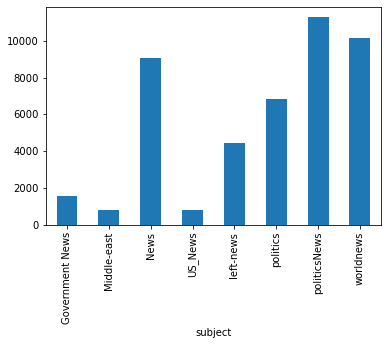

In [19]:
# How many articles per subject?

print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

target
fake    23481
true    21417
Name: text, dtype: int64


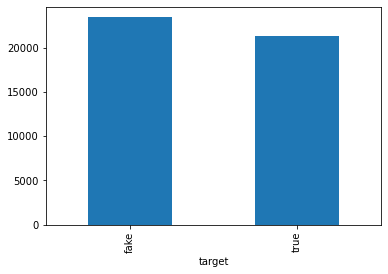

In [20]:
# How many fake and real articles?

print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.show()

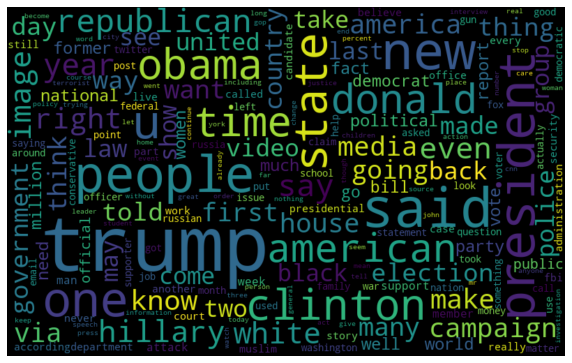

In [22]:
# Word cloud for fake news

from wordcloud import WordCloud

fake_data = data[data["target"] == "fake"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

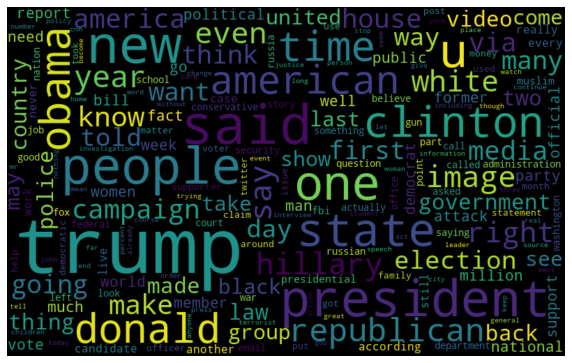

In [23]:
# Word cloud for real news

real_data = data[data["target"] == "true"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [24]:
# Most frequent words counter (Code adapted from https://www.kaggle.com/rodolfoluna/fake-news-detector)   

from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

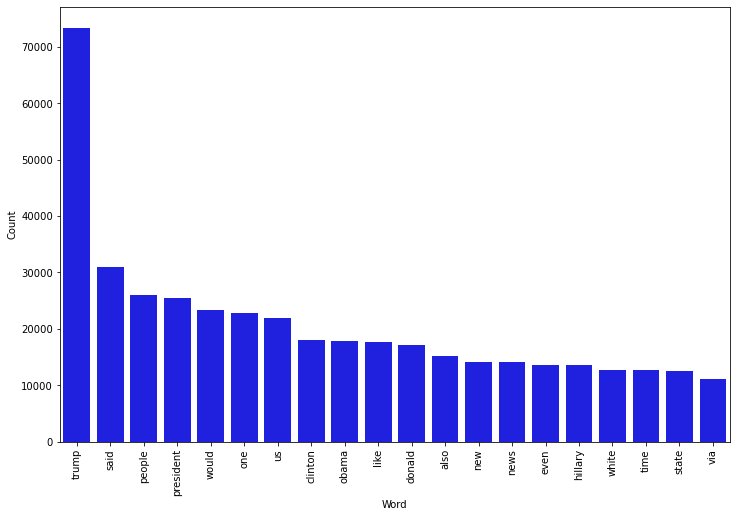

In [25]:
# Most frequent words in fake news

counter(data[data["target"] == "fake"], "text", 20)

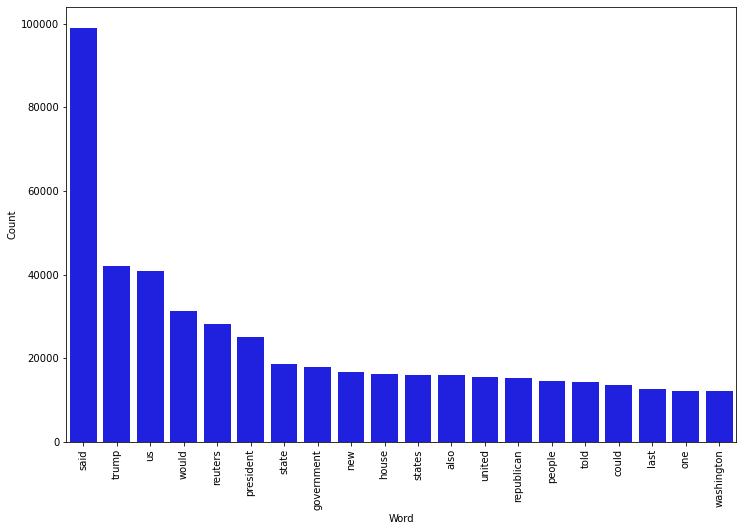

In [26]:
# Most frequent words in real news

counter(data[data["target"] == "true"], "text", 20)

# modelling

In [28]:
# Function to plot the confusion matrix (code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)


from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# spitting the data

In [29]:
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

# Logistic Regression

In [36]:
# Vectorizing and applying TF-IDF
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
acc_lr=round(accuracy_score(y_test, prediction)*100,2)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

98.71
accuracy: 98.71%


Confusion matrix, without normalization


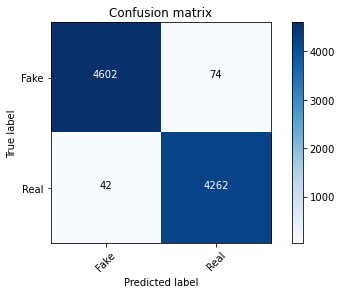

In [31]:
#Confusion matrix for Logistic Regression
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# Decision Tree Classifier

In [32]:
from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])
# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
acc_dtc=round(accuracy_score(y_test, prediction)*100,2)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 99.57%


Confusion matrix, without normalization


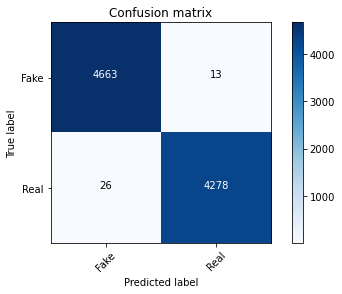

In [33]:
#Confusion matrix for Decision Tree Classifier
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# Random Forest Classifier

In [34]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
acc_rfc=round(accuracy_score(y_test, prediction)*100,2)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 99.11%


Confusion matrix, without normalization


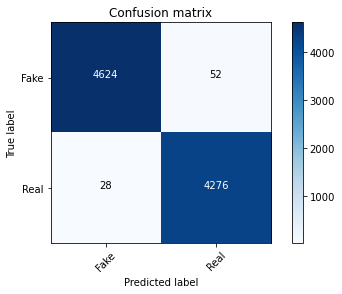

In [35]:
#Confusion matrix for Random Forest Classifier
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# visualization of the performance of the algorithms

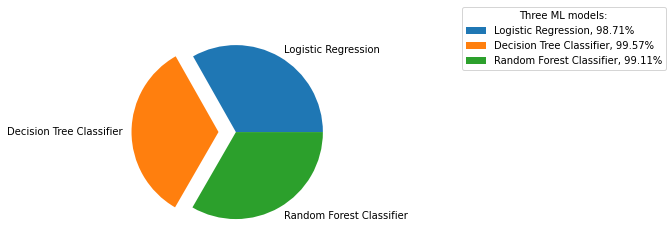

In [55]:
#pie chart visualization
y = np.array([98.71, 99.57, 99.11])
mylabels = ["Logistic Regression", "Decision Tree Classifier", "Random Forest Classifier"]
myexplode = [0, 0.2, 0]

plt.pie(y, labels = mylabels, explode = myexplode)
labels = [f'{l}, {s:0.2f}%' for l, s in zip(mylabels, y)]
plt.legend(bbox_to_anchor=(2.5, 1.1),title = "Three ML models:",labels = labels)
plt.show() 